# <b> Time-Series Forecasting of Volatility and Option Pricing </b>



The project aims to perform time series forecasting on trailing volatility of AAPL and use it to predict option price using Black-Scholes model.
It can be summarizes as three parts:

1) Analyzed AAPL's risk and return features, performed exploratory data analysis and trend and seasonal decomposition.

2) Tested for stationarity and constructed ARMA, ARIMA, and SARIMA models and grid searched for hyperparameters tuning.

3) Forecasted AAPL 30-day trailing volatility with the best-fitted model and predicted option price using Black-Scholes model.

## Fetch Market Data

In [ ]:
# import libraries
from datetime import datetime
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import yfinance as yf
import os
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# get tickers
user_input = input("Enter ticker: ")
ticker = yf.Ticker(user_input)
tbill = yf.Ticker("^IRX") # treasury bill
snp = yf.Ticker("^GSPC") # S&P 500

Enter ticker: AAPL


In [ ]:
# fetch historical market data from Yahoo Finance
hist = ticker.history(period="5y", interval="1d", auto_adjust=True, actions=False)
hist_tbill = tbill.history(period="5y", interval="1d", actions=False)
hist_snp = snp.history(period="5y", interval="1d", actions=False)

In [ ]:
# set index format and remove time zone info
hist.index = pd.to_datetime(hist.index, format='%Y%m%d')
hist.index = hist.index.tz_localize(None)

## Explorative Data Analysis

In [ ]:
# add daily return
hist["Return"] = hist.Close / hist.Close.shift(1) - 1

# add trailing 30-day volatility
trailing_vol = hist.Return.rolling(window=22).std() * np.sqrt(252)

hist["Trailing_Volatility"] = trailing_vol

# add previous peak
hist["Previous_Peak"] = hist.High.cummax()

# add drawdown
hist["Drawdown"] = (hist["Close"] - hist["Previous_Peak"]) / hist["Previous_Peak"]

hist.head()

,Open,High,Low,Close,Volume,Return,Trailing_Volatility,Previous_Peak,Drawdown
Date,,,,,,,,,
2018-10-24,53.297872,53.688146,51.368036,51.499725,163702000,NaN,NaN,53.688146,-0.040762
2018-10-25,52.127049,53.005770,51.897192,52.627464,119423200,0.021898,NaN,53.688146,-0.019756
2018-10-26,51.693672,52.720844,50.920303,51.789448,189033600,-0.015924,NaN,53.688146,-0.035365
2018-10-29,52.481418,52.601135,49.344838,50.817356,183742000,-0.018770,NaN,53.688146,-0.053472
2018-10-30,50.556360,51.521276,50.106228,51.071144,146640000,0.004994,NaN,53.688146,-0.048745


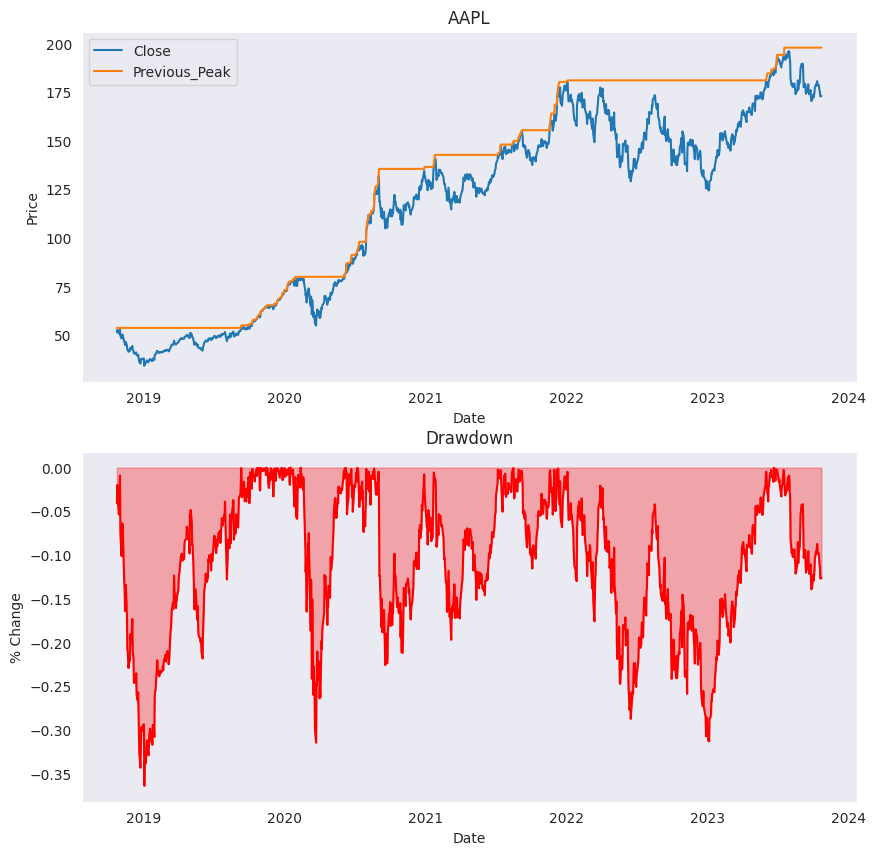

In [ ]:
# visualize stock profile
sns.set_style("dark")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sns.lineplot(data=hist[["Close", "Previous_Peak"]], dashes=False)
plt.title(user_input)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

plt.subplot(2, 1, 2)
ax = sns.lineplot(x=hist.index, y=hist.Drawdown, color="red")
ax.fill_between(hist.index, hist.Drawdown, alpha=0.3, color="red")
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("% Change")
plt.show()

In [ ]:
# calculate annualized return
annualized_return = (1 + hist.Return).prod()**(252/hist.Return.shape[0]) - 1

# calculate annualized volatility
annualized_vol = hist.Return.std() * np.sqrt(252)

# calculate maximum drawdown
mdd = hist.Drawdown.min()

# calculate sharp ratio
rf = hist_tbill.Close.iloc[-1] / 100
sharpe_ratio = (annualized_return - rf) / annualized_vol

# calculate calmar ratio
calmar_ratio = annualized_return / -hist["Drawdown"].rolling(window=756).min()

# get returns of S&P 500
hist_snp["Return"] = hist_snp.Close.pct_change()
# calculate beta
cm = np.cov(hist.Return.dropna(), hist_snp.Return.dropna())
beta = cm[0][1] / cm[1][1]

print("Stock:", user_input)
print(f"Annualized Return: {(annualized_return*100):.2f}%")
print(f"Annualized Volatility: {(annualized_vol*100):.2f}%")
print(f"Max Drawdown: {(mdd*100):.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio.iloc[-1]:.2f}")
print(f"Beta: {beta:.2f}")

Stock: AAPL
Annualized Return: 27.50%
Annualized Volatility: 33.17%
Max Drawdown: -36.37%
Sharpe Ratio: 0.67
Calmar Ratio: 0.88
Beta: 1.23


**Visualizes the time series**

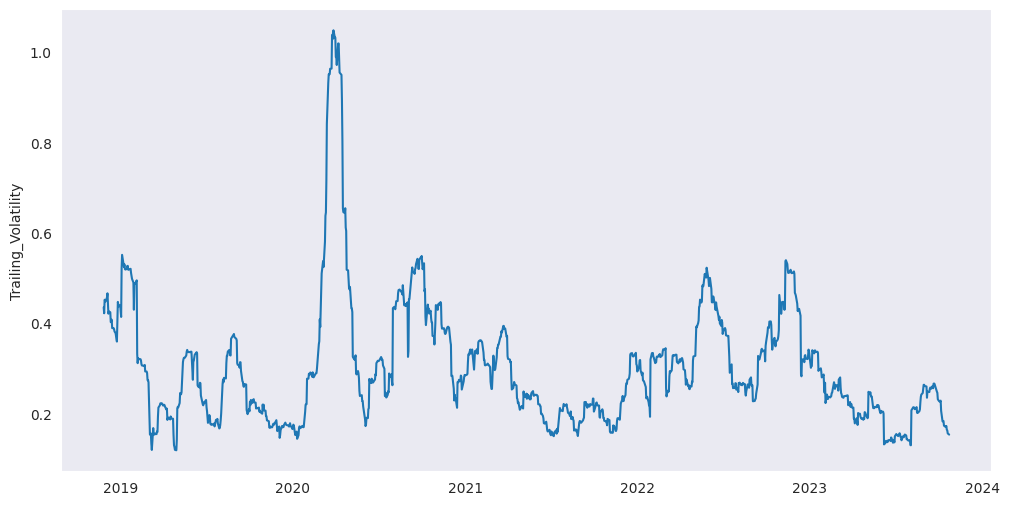

In [ ]:
# drop rows that contain missing values
hist = hist.dropna()

# plot time series
series = ["Trailing_Volatility"]

plt.figure(figsize=(12, 6))
for i in range(len(series)):
  plt.subplot(len(series), 1, i+1)
  plt.plot(hist.index, hist[series[i]])
  plt.ylabel(series[i])
plt.show()

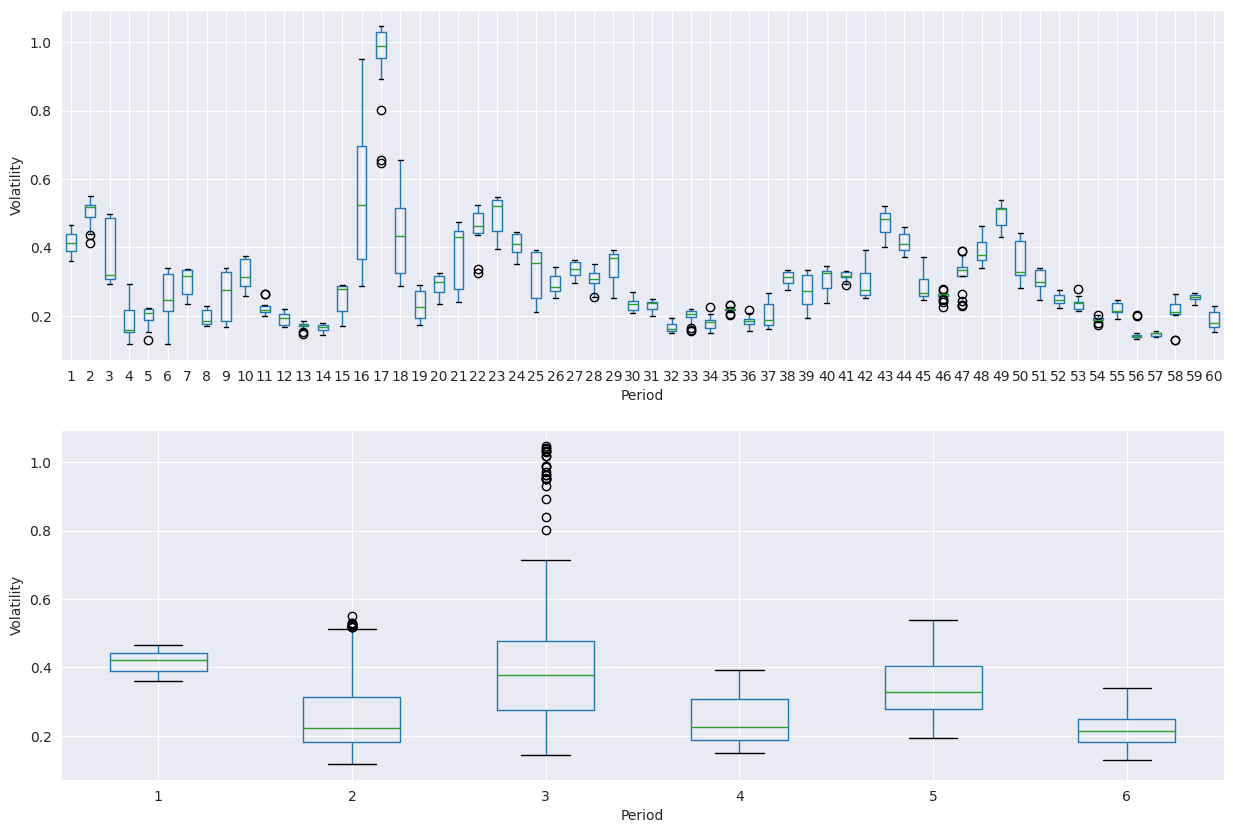

In [ ]:
# define boxplot function
def group_boxplot(series: pd.Series, freq: str) -> pd.DataFrame:
  '''
  Group given series at specified frequency and plot boxplot.
  series: pd.Series
  freq: string
  '''
  grouped_df = series.groupby(pd.Grouper(freq=freq))
  df = pd.concat([pd.DataFrame(x[1].values) for x in grouped_df], axis=1)
  df = pd.DataFrame(df)
  df.columns = [i for i in range(1, df.shape[1]+1)]
  return df

# plot 30 day period volatility
month_df = group_boxplot(hist["Trailing_Volatility"], "30D")
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
month_df.boxplot()
plt.xlabel("Period")
plt.ylabel("Volatility")

# plot annual period volatility
year_df = group_boxplot(hist["Trailing_Volatility"], "Y")
plt.subplot(2, 1, 2)
year_df.boxplot()
plt.xlabel("Period")
plt.ylabel("Volatility")
plt.show()

**Observation:**
*   The 30 day historical volatility of AAPL is generally ranging from 20 to 50%.
*   The volatility variation is relatively constant over time.

**Trend and Seasonal Decomposition: Additive Model**

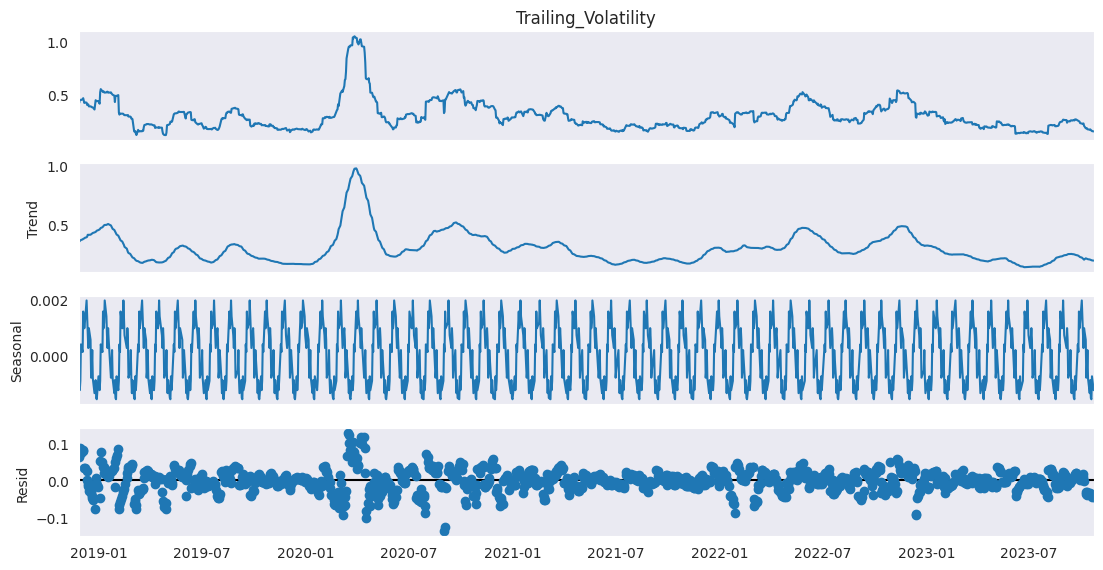

In [ ]:
# decompose trailing volatility by trend, seasonality, and residuals
decomposed = sm.tsa.seasonal_decompose(hist["Trailing_Volatility"], model="additive", period=22, extrapolate_trend="freq")
fig = decomposed.plot()
fig.set_size_inches(12, 6)
plt.show()

In [ ]:
# view the decomposition dataframe
decomposed_df = pd.concat([decomposed.trend, decomposed.seasonal, decomposed.resid, decomposed.observed], axis=1)
decomposed_df.columns = ["Trend", "Seasonality", "Residual", "Observed"]
decomposed_df.head()

,Trend,Seasonality,Residual,Observed
Date,,,,
2018-11-26,0.354526,-0.001551,0.081839,0.434814
2018-11-27,0.359112,-0.000737,0.063410,0.421785
2018-11-28,0.363697,-0.001229,0.089245,0.451714
2018-11-29,0.368282,-0.000899,0.082575,0.449959
2018-11-30,0.372868,0.000394,0.074735,0.447997


## Model Building: ARMA, ARIMA, and SARIMA

Let's consider the data from the last 252 days as the test data and the remaining as the train data.

In [ ]:
# split data into train and test sets
df_train, df_test = hist["Trailing_Volatility"].iloc[:-252], hist["Trailing_Volatility"].iloc[-252:]

print(df_train.shape)
print(df_test.shape)

(983,)
(252,)


**Augmented Dickey-Fuller (ADF) Test**: Test for stationarity

In [ ]:
# define function for ADF test
def adf_test(data: pd.Series) -> None:
  '''
  Perform ADF test on input series.
  data: pd.Series
  Returns: None
  '''
  adf = adfuller(data, regression='c', autolag="AIC")
  print("Test Statistic:", adf[0])
  print("p-value:", adf[1])
  print("n_lags:", adf[2])
  print("No of observations:", adf[3])
  for key, value in adf[4].items():
    print(f"critical value {key}: {value}")

In [ ]:
# ADF test whether the time series is stationary
adf_test(df_train)

Test Statistic: -3.09044845530502
p-value: 0.0272681681526573
n_lags: 22
No of observations: 960
critical value 1%: -3.437180074590612
critical value 5%: -2.8645553686071326
critical value 10%: -2.5683755479600694


**Observation:**

Given the fact that the ADF test statistic is smaller than the 5% critical values but larger than 1% critical value, and the p-value is smaller than 0.05 but significantly larger than 0.

Let's take a first order differencing and see the result.

**First Order Differencing**

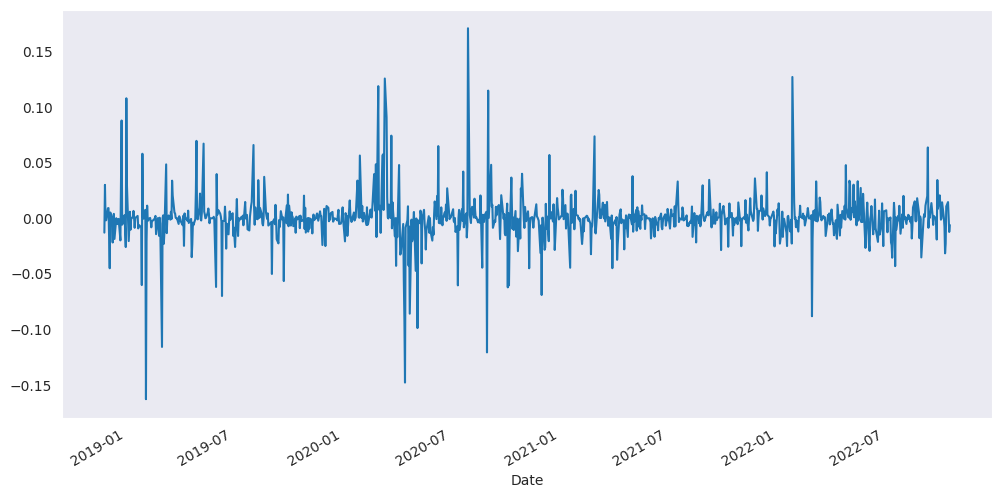

Test Statistic: -9.411174413622604
p-value: 5.82985119594872e-16
n_lags: 21
No of observations: 960
critical value 1%: -3.437180074590612
critical value 5%: -2.8645553686071326
critical value 10%: -2.5683755479600694


In [ ]:
# taking the 1st order differencing
df_train_first = df_train.diff().dropna()

# plot the differenced time series
plt.figure(figsize=(12,6))
df_train_first.plot()
plt.show()

# test for ADF test
adf_test(df_train_first)

**Observation:**
As we can see the p-value is near zero, and from the plot we can visually confirm that the differenced time series is stationary.

**Determine the orders of Moving Average (MA) and Autoregression (AR) by Auto Correlation Function (ACF) and Partial Auto Correlation Function (PACF)**

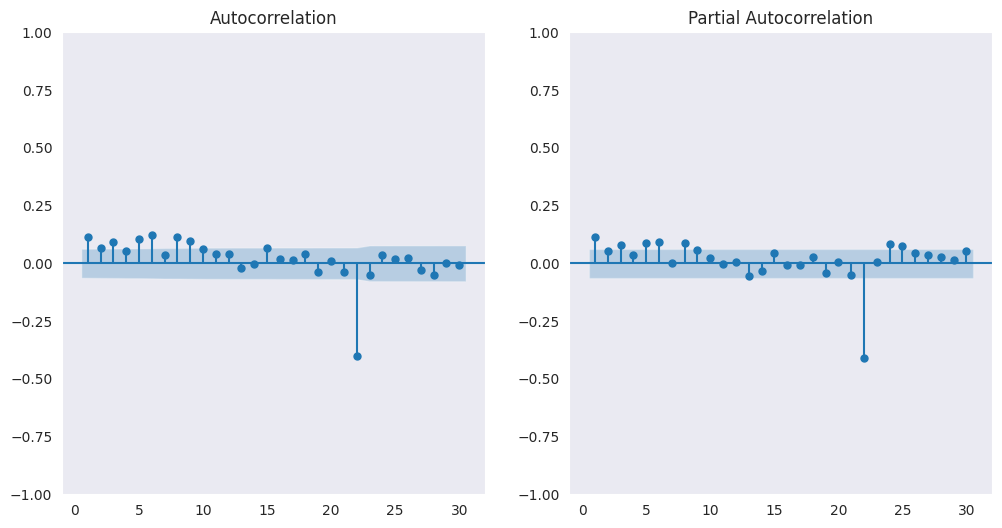

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# ACF plot
fig = plot_acf(df_train_first, alpha=0.05, zero=False, ax=axes[0])
# PACF plot
fig = plot_pacf(df_train_first, alpha=0.05, zero=False,ax=axes[1])

**Observation:**

From the above ACF and PACF plots, we observed that the lags that at which the plot extends the confidence interval are **lag 1, 3, 5, 6, 8, 22** and **lag 1, 5, 6, 8, 22** respectively. The highest lags at 22 may imply the presence of seasonality.

We will construct ARMA, ARIMA and SARIMA models, grid search the optimal parameters, and compare their RMSE and AIC to determine the best model.

### Autoregressive Moving Average (ARMA) Model

In [ ]:
# define grid search function
def grid_search_ARIMA(parameters, monitor="aic"):
  '''
  Perform grid search on input parameters for ARIMA-type model.
  parameters: search parameters in terms of ARIMA(p, d, q)
  monitor: {"rmse", "aic"}, default="aic"
  Returns: (best_parameters, best_model_results)
  '''
  grid = itertools.product(*parameters.values())

  best_score = float("inf")
  best_param = None
  best_results = None

  # model fitting
  for param in grid:
    model = ARIMA(df_train_first, order=param)
    results = model.fit()

    if monitor == "aic":
      best_score = min(best_score, results.aic)
      best_param = param
      best_results = results

    elif monitor == "rmse":
      best_score = min(best_score, mean_squared_error(df_train_first, results.fittedvalues, squared=False))
      best_param = param
      best_results = results

  print("best parameters:", best_param)
  print(f"{monitor}: {best_score}")
  return best_param, best_results

In [ ]:
# grid search parameters for ARMA model
search_parameters = {
    'p': [1, 5, 6, 8, 22],
    'd': [0],
    'q': [1, 3, 5, 6, 8, 22]
}
param, results_ARMA = grid_search_ARIMA(search_parameters, "aic")

best parameters: (22, 0, 22)
aic: -5040.689702839496


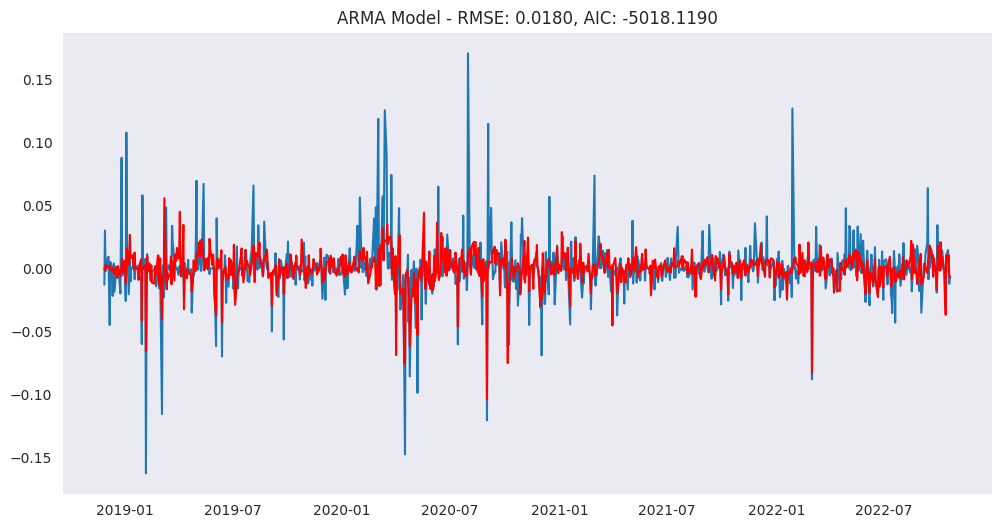

In [ ]:
# visualize the result
plt.figure(figsize=(12, 6))
plt.plot(df_train_first)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title(
    "ARMA Model - RMSE: %.4f"% mean_squared_error(df_train_first, results_ARMA.fittedvalues, squared=False) +
    ', AIC: %.4f'% results_ARMA.aic
)
plt.show()

### Autoregressive Integrated Moving Average (ARIMA) Model

Since our time series is already differenced, fitting it in ARIMA with d = 1 will result in double differencing.

In [ ]:
# define search parameters and build an ARIMA
search_parameters = {
    'p': [1, 5, 6, 8, 22],
    'd': [1],
    'q': [1, 3, 5, 6, 8, 22]
}

param, results_ARIMA = grid_search_ARIMA(search_parameters, "aic")

best parameters: (22, 1, 22)
aic: -5007.756554471912


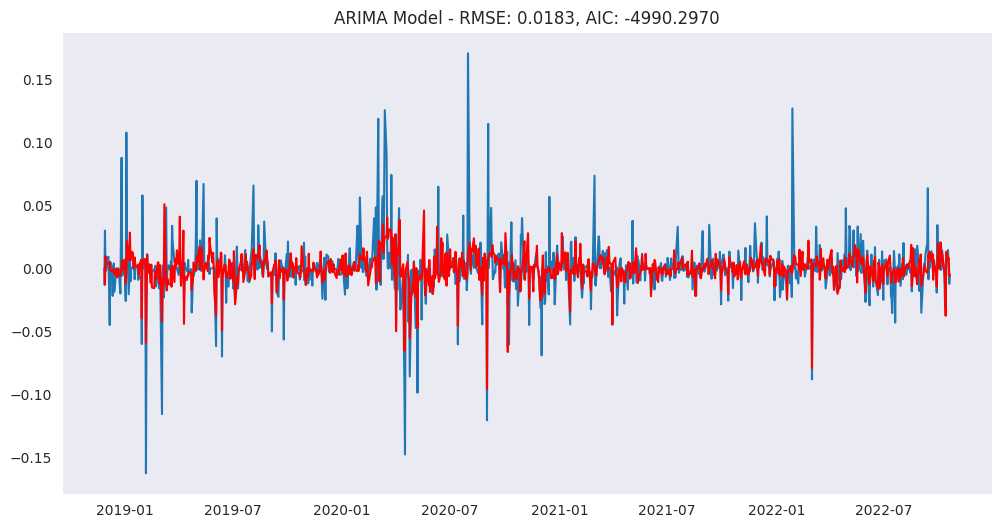

In [ ]:
# visualize the result
plt.figure(figsize=(12, 6))
plt.plot(df_train_first)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title(
    "ARIMA Model - RMSE: %.4f"% mean_squared_error(df_train_first, results_ARIMA.fittedvalues, squared=False) +
    ', AIC: %.4f'% results_ARIMA.aic
)
plt.show()

### Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

As we observed from ACF and PACF plots, the lag 22 are significant in both plots. And considering AAPL announces earning calls quarterly, we will grid search seasonal order with s = 22 and 63.

In [ ]:
# define function to build and evaluate SARIMA model
def evaluate_SARIMA(train_data, order, seasonal_order):
  '''
  train_data: train data set
  order: trend order in (p, d, q)
  seasonal_order: seasonal order in (P, D, Q, s)
  Returns: (aic_score, fitted_model)
  '''
  # initialize return values
  aic = None
  results_SARIMA = None

  try:
    model_SARIMA = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    results_SARIMA = model_SARIMA.fit()
    aic = results_SARIMA.aic

  except:
    pass

  return aic, results_SARIMA

In [ ]:
# define function to grid search parameters in parallel
def grid_search_SARIMA(train_data, orders, seasonal_orders):
  '''
  Grid search trend and seasonal orders to find the best fitted model.
  train_data: train data set
  orders: a list of trend orders
  seasonal_orders: a list of seasonal orders
  Returns: (best_score, best_model)
  '''
  best_score = float("inf")

  results = Parallel(n_jobs=os.cpu_count(), backend="multiprocessing")(
      delayed(evaluate_SARIMA)(train_data, order, seasonal_order)
      for order in orders for seasonal_order in seasonal_orders
  )
  best_score, best_model = min(results, key=lambda x: x[0])

  return best_score, best_model

In [ ]:
# define search parameters
orders = [(8, 0, 8), (8, 1, 8)]
seasonal_orders = list(
    itertools.product(range(2), range(2), range(2),
                      [22, 63])
)

score_SARIMA, results_SARIMA = grid_search_SARIMA(df_train_first, orders, seasonal_orders)
print(f"AIC: {score_SARIMA:.4f}")

AIC: -5041.4349


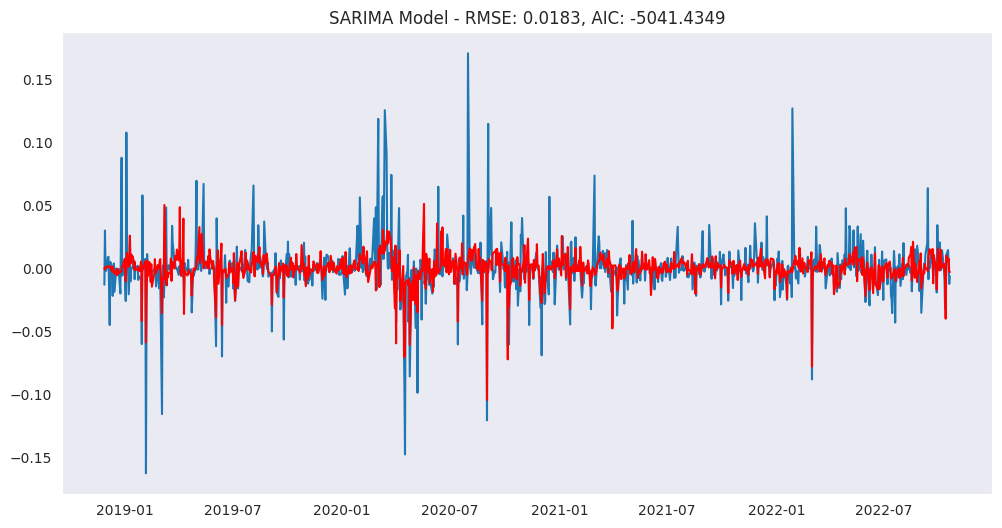

In [ ]:
# visualize the result
plt.figure(figsize=(12, 6))
plt.plot(df_train_first)
plt.plot(results_SARIMA.fittedvalues, color='red')
plt.title(
    "SARIMA Model - RMSE: %.4f"% mean_squared_error(df_train_first, results_SARIMA.fittedvalues, squared=False) +
    ', AIC: %.4f'% results_SARIMA.aic
)
plt.show()

In [ ]:
# view the result
print(results_SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  Trailing_Volatility   No. Observations:                  982
Model:             SARIMAX(8, 0, 8)x(1, 0, [1], 22)   Log Likelihood                2539.717
Date:                              Tue, 24 Oct 2023   AIC                          -5041.435
Time:                                      02:15:06   BIC                          -4948.533
Sample:                                           0   HQIC                         -5006.095
                                              - 982                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0201      1.213      0.017      0.987      -2.357       2.398
ar.L2          0.02

**Observation:**

All three models resulted in similar score in term of RMSE. The SARIMA model with trend order (8, 0, 8) and seasonal order (1, 0, 1, 22) gave us the lowest AIC so far, we will use the SARIMA for option pricing.

## Time-series Forecasting

Let's forecast 14-day period with SARIMA model and compare with the test set.

In [ ]:
# get the in-sample prediction and out-of-sample forecasting
predictions = results_SARIMA.predict(start=0, end=df_train.shape[0] + 14)

# inverse transform values
predict_transformed = predictions.cumsum() + df_train.iloc[-1]

# make a new dataframe for forecasted values
predictions_df = pd.DataFrame({"Date": pd.concat([df_train, df_test[:14]], axis=0).reset_index().Date, "Predicted": predict_transformed.reset_index().predicted_mean})
predictions_df.set_index("Date", inplace=True)

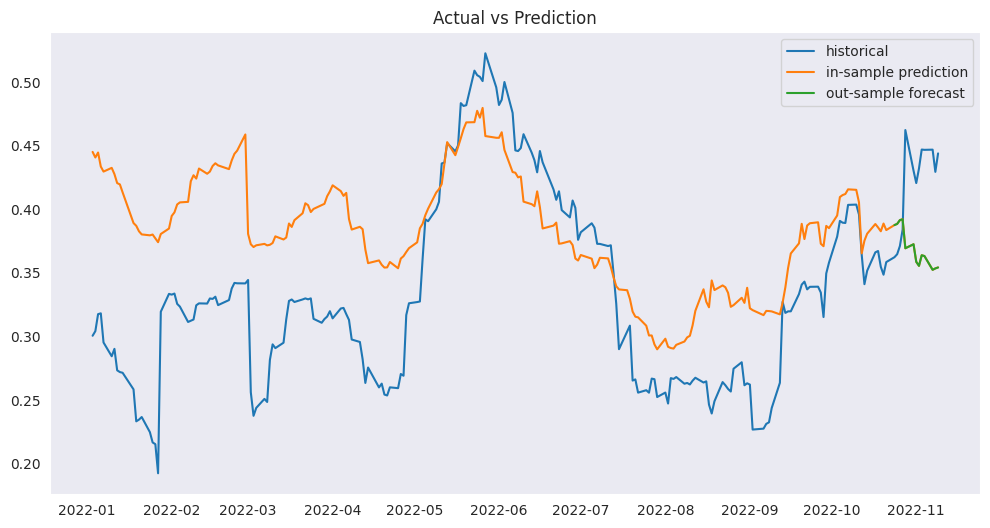

In [ ]:
# visualize the historical and forecasted series
plt.figure(figsize=(16, 6))
plt.plot(pd.concat([df_train, df_test[:14]], axis=0)["2022-01-01":], color="tab:blue", label="historical")
plt.plot(predictions_df["2022-01-01":], color="tab:orange", label="in-sample prediction")
plt.plot(predictions_df[-14:], color="tab:green", label="out-sample forecast")

plt.title("Actual vs Prediction")
plt.legend()
plt.show()

In [ ]:
# calculate the RMSE on the forecast
rmse = mean_squared_error(df_test[:14], predictions_df[-14:], squared=False)

print("RMSE for test data:", rmse)

RMSE for test data: 0.06607248738464336


Let's train the data on the whole data set

In [ ]:
# first order differencing
df_first = hist["Trailing_Volatility"].diff().dropna()

# fitting the model on the whole data set
model_final = SARIMAX(df_first, order=(8, 0, 8), seasonal_order=(1, 0, 1, 22))
results_final = model_final.fit()

## Option Pricing with Black-Scholes Model

In [ ]:
# define black-scholes function
def black_scholes(S, K, T, r, sigma):
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  put = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
  return call, put

In [ ]:
# estimate the option price
today = datetime.today()
print("Today: ", today.date())
K = float(input("Strike Price: "))
expiry_date = input("Expiry Date (YYYY-MM-DD): ")
expiry_date = datetime.strptime(expiry_date, "%Y-%m-%d")
steps = (expiry_date - today).days
T = steps / 365

forecasted = results_ARIMA.forecast(steps=steps)
# inverse transform values
forecasted_values = forecasted.cumsum() + hist["Trailing_Volatility"].iloc[-1]
call, put = black_scholes(hist.Close.iloc[-1], K, T, rf, forecasted_values.iloc[-1])

print("Call Price:", call)
print("Put Price:", put)

Today:  2023-10-24
Strike Price: 180
Expiry Date (YYYY-MM-DD): 2023-11-24
Call Price: 0.9159926918712813
Put Price: 7.134619566071336
